### Load the libraries

In [1]:
import os
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.absolute()))
os.chdir("..") # change to repo root dir

In [2]:
os.getcwd()

'/home/zihan/bimaminobolonana'

In [3]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from encoder import build_encoder
from encoder.transforms import build_image_transform, prepare_batch
from train.dataset import TensorBimanualObs, TensorBimanualAction
from train.trainer import BimanualActor,BCTrainer
from encoder.transforms import build_image_transform
import yaml


print("Environment ready.")

/home/zihan/miniconda3/envs/dev/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Environment ready.


In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Then we are going to generate some data, using the image generated to test the encoder
We only generate some of them, so we stop early

In [4]:
dataset_dir_path = Path('bc-train-data-test')

from train.dataset import generate_bimanual_dataset

generate_bimanual_dataset(
  save_dir=dataset_dir_path,
  total_sample_count=10000,
  max_steps_per_rollout=600,
  skip_frames=2,
  camera_dims=(128, 128),
  resume=True
)

Bimanual dataset save directory is set to `bc-train-data-test`.
Allocating 3.93GB in `bc-train-data-test`...


Attempting rollout 0.:  80%|████████  | 483/600 [01:10<00:17,  6.81it/s]


 - Rollout succeeded. Saved 162 samples at 2025-10-31 21:12:47.180004. (162/10000)


Attempting rollout 1.:  51%|█████     | 306/600 [02:13<02:08,  2.29it/s]


KeyboardInterrupt: 

In [5]:
# View the generated data
from train.dataset import BimanualDataset
from pathlib import Path

dataset = BimanualDataset(Path("train/bc-train-data-test"))

print(f"Dataset length: {len(dataset)}")

obs, act = dataset[0]

print("visual:", obs.visual.shape)
print("qpos:", obs.qpos.array.shape)
print("qvel:", obs.qvel.array.shape)
print("action:", act.array.shape)


Dataset length: 162
visual: torch.Size([1, 2, 128, 128, 3])
qpos: torch.Size([1, 16])
qvel: torch.Size([1, 16])
action: torch.Size([1, 14])


/home/zihan/bimaminobolonana/train/dataset.py:129: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  self._observation_array = torch.from_numpy(observation_array)


### Display the left and right image

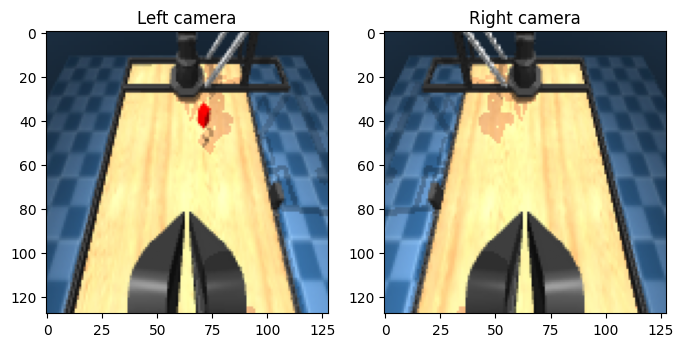

In [6]:
import matplotlib.pyplot as plt

left_img = obs.visual[0, 0].numpy()
right_img = obs.visual[0, 1].numpy()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(left_img)
plt.title("Left camera")
plt.subplot(1,2,2)
plt.imshow(right_img)
plt.title("Right camera")
plt.show()

### Then we pass one pair of image to the encoder

In [7]:
# Please change to the correct config file path and specify the correct model architecture as needed
with open("configs/encoder_pri3d_random.yaml", "r") as f:
    cfg = yaml.safe_load(f)

encoder = build_encoder(cfg)
encoder.eval()

left_imgs = obs.visual[:, 0].permute(0, 3, 1, 2)   # [B, 3, 128, 128]
right_imgs = obs.visual[:, 1].permute(0, 3, 1, 2)

with torch.no_grad():
    out = encoder.encode((left_imgs, right_imgs))

# Output the encoder results for inspection
print("==== Encoder Output ====")
for k, v in out.items():
    print(f"{k}: shape={v.shape}, dtype={v.dtype}")
    print(v[0, :10])  

==== Encoder Output ====
left: shape=torch.Size([1, 512]), dtype=torch.float32
tensor([ 3.5823,  0.8009, -8.0934, -5.0568, -2.4537,  8.3417, -7.2470,  2.4432,
        -8.1627, -6.4600])
right: shape=torch.Size([1, 512]), dtype=torch.float32
tensor([ 3.5031,  0.7630, -8.0706, -4.9228, -2.4902,  8.3349, -7.1923,  2.4243,
        -8.1485, -6.3772])
fused: shape=torch.Size([1, 512]), dtype=torch.float32
tensor([ 3.5427,  0.7819, -8.0820, -4.9898, -2.4720,  8.3383, -7.2197,  2.4338,
        -8.1556, -6.4186])


In [8]:
class BimanualPri3DActor(BimanualActor):
    def __init__(
        self,
        encoder_cfg_path="configs/encoder_pri3d_random.yaml",
        state_dim=32,
        hidden_dim=512,
        action_dim=14
    ):
        super().__init__()

        # --- Load Pri3D encoder ---
        with open(encoder_cfg_path, "r") as f:
            cfg = yaml.safe_load(f)
        self.encoder = build_encoder(cfg)
        self.encoder.eval()  # frozen encoder

        # --- Freeze encoder weights ---
        for p in self.encoder.parameters():
            p.requires_grad = False

        # --- Projection MLP for fusion ---
        self.mlp = nn.Sequential(
            nn.Linear(512 + state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, action_dim)
        )

    def forward(self, obs: TensorBimanualObs) -> TensorBimanualAction:
        
        left_imgs  = obs.visual[:, 0].permute(0, 3, 1, 2)  # [B, 3, H, W]
        right_imgs = obs.visual[:, 1].permute(0, 3, 1, 2)

        with torch.no_grad():
            feats = self.encoder.encode((left_imgs, right_imgs))
            fused_feat = feats["fused"]  # [B, 512]

        state_feat = torch.cat([obs.qpos.array, obs.qvel.array], dim=-1)  # [B, 32]
        x = torch.cat([fused_feat, state_feat], dim=-1)

        out = self.mlp(x)
        return TensorBimanualAction(out)

In [9]:
from torch.utils.data import DataLoader
from train.dataset import BimanualDataset
from train.train_utils import Logs
from train.trainer import BCTrainer

dataset = BimanualDataset("train/bc-train-data-test")
dataloader = DataLoader(dataset, batch_size=32, collate_fn=BimanualDataset.collate_fn)

# create the out directory for training logs
make_dir = Path("out/training-output")
make_dir.mkdir(parents=True, exist_ok=True)


logs = Logs("out/training-output")
job = logs.create_new_job(tag="bc-pri3d")

model = BimanualPri3DActor().cuda()
trainer = BCTrainer(dataloader, checkpoint_frequency=1, job=job)
trainer.train(model, num_epochs=5)

Training model for 5 epochs.


Epoch 0: 100%|██████████| 6/6 [00:00<00:00,  8.93it/s]


 - Epoch 0 loss: 2.4963


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 14.59it/s]


 - Epoch 1 loss: 3.9686


Epoch 2: 100%|██████████| 6/6 [00:00<00:00, 14.54it/s]


 - Epoch 2 loss: 1.4730


Epoch 3: 100%|██████████| 6/6 [00:00<00:00, 14.49it/s]


 - Epoch 3 loss: 1.1438


Epoch 4: 100%|██████████| 6/6 [00:00<00:00, 14.57it/s]


 - Epoch 4 loss: 1.3426


### We can also load the pretrained weights 


In [7]:
# Load config for pretrained Pri3D encoder
with open("configs/encoder_pri3d_pretrained.yaml", "r") as f:
    cfg = yaml.safe_load(f)

encoder = build_encoder(cfg).eval().cuda()

left = prepare_batch(Image.new("RGB", (224,224), (255,0,0)), build_image_transform("imagenet", 224))
right = prepare_batch(Image.new("RGB", (224,224), (0,255,0)), build_image_transform("imagenet", 224))

with torch.no_grad():
    out = encoder.encode((left, right))
print(out["fused"].shape)

# Test on dataset images
left_imgs = obs.visual[:, 0].permute(0, 3, 1, 2)   # [B, 3, 128, 128]
right_imgs = obs.visual[:, 1].permute(0, 3, 1, 2)

with torch.no_grad():
    out = encoder.encode((left_imgs, right_imgs))

# Output the encoder results for inspection
print("==== Encoder Output ====")
for k, v in out.items():
    print(f"{k}: shape={v.shape}, dtype={v.dtype}")
    print(v[0, :10])  

/home/zihan/bimaminobolonana/encoder/pri3d.py:88: UserWarning: Pri3D ckpt loaded from '/mnt/data/ScanNet_Combine_BatchSize64_LearningRate01_Epoch5_ImageSize240x320_ResNet50.pth': matched=318, missing=0, unexpected=455
  warnings.warn(f"Pri3D ckpt loaded from '{ckpt_path}': matched={matched}, missing={len(missing)}, unexpected={len(unexpected)}")


torch.Size([1, 512])
==== Encoder Output ====
left: shape=torch.Size([1, 512]), dtype=torch.float32
tensor([ 0.0808,  0.1112, -0.0935,  0.0569,  0.0389,  0.0455, -0.0041, -0.0364,
         0.0225, -0.0255], device='cuda:0')
right: shape=torch.Size([1, 512]), dtype=torch.float32
tensor([ 0.0565,  0.1207, -0.0477,  0.0238,  0.0301,  0.0128, -0.0362, -0.0429,
        -0.0098, -0.0201], device='cuda:0')
fused: shape=torch.Size([1, 512]), dtype=torch.float32
tensor([ 0.0686,  0.1159, -0.0706,  0.0403,  0.0345,  0.0292, -0.0202, -0.0396,
         0.0063, -0.0228], device='cuda:0')


In [8]:
class BimanualPri3DActor(nn.Module):
    def __init__(self, encoder_cfg_path="configs/encoder_pri3d_pretrained.yaml",
                 state_dim=32, hidden_dim=512, action_dim=14):
        super().__init__()

        # --- Load and freeze Pri3D encoder ---
        with open(encoder_cfg_path, "r") as f:
            cfg = yaml.safe_load(f)
        self.encoder = build_encoder(cfg)
        self.encoder.eval()
        for p in self.encoder.parameters():
            p.requires_grad = False

        # --- Fusion MLP ---
        self.mlp = nn.Sequential(
            nn.Linear(512 + state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, action_dim)
        )

    def forward(self, obs: TensorBimanualObs) -> TensorBimanualAction:
        left_imgs  = obs.visual[:, 0].permute(0, 3, 1, 2)
        right_imgs = obs.visual[:, 1].permute(0, 3, 1, 2)

        with torch.no_grad():
            feats = self.encoder.encode((left_imgs, right_imgs))
            fused_feat = feats["fused"]

        state_feat = torch.cat([obs.qpos.array, obs.qvel.array], dim=-1)
        x = torch.cat([fused_feat, state_feat], dim=-1)
        out = self.mlp(x)
        return TensorBimanualAction(out)

### Then we start training

In [9]:
from torch.utils.data import DataLoader
from train.dataset import BimanualDataset
from train.trainer import BCTrainer
from train.train_utils import Logs
import os

dataset_dir_path = "train/bc-train-data-test"
dataset = BimanualDataset(dataset_dir_path)
dataloader = DataLoader(dataset, batch_size=64, collate_fn=BimanualDataset.collate_fn)

os.makedirs("out/training-pri3d", exist_ok=True)
logs = Logs("out/training-pri3d")
job = logs.create_new_job(tag="pri3d-bc")

model = BimanualPri3DActor().cuda()
trainer = BCTrainer(dataloader, checkpoint_frequency=1, job=job)

trainer.train(model, num_epochs=10)


Training model for 10 epochs.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]


 - Epoch 0 loss: 1.9233


Epoch 1: 100%|██████████| 3/3 [00:00<00:00,  7.19it/s]


 - Epoch 1 loss: 1.1945


Epoch 2: 100%|██████████| 3/3 [00:00<00:00,  7.21it/s]


 - Epoch 2 loss: 0.6392


Epoch 3: 100%|██████████| 3/3 [00:00<00:00,  7.13it/s]


 - Epoch 3 loss: 0.7110


Epoch 4: 100%|██████████| 3/3 [00:00<00:00,  7.18it/s]


 - Epoch 4 loss: 0.4796


Epoch 5: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s]


 - Epoch 5 loss: 0.3854


Epoch 6: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s]


 - Epoch 6 loss: 0.3347


Epoch 7: 100%|██████████| 3/3 [00:00<00:00,  7.18it/s]


 - Epoch 7 loss: 0.2659


Epoch 8: 100%|██████████| 3/3 [00:00<00:00,  7.13it/s]


 - Epoch 8 loss: 0.2224


Epoch 9: 100%|██████████| 3/3 [00:00<00:00,  7.13it/s]


 - Epoch 9 loss: 0.1669


### Also we can try the CLIP encoder, just load from one of the two yaml file you want

In [ ]:
# Load config for pretrained CLIP encoder 

with open("configs/encoder_clip_b32_openai.yaml", "r") as f:
    cfg = yaml.safe_load(f)

encoder = build_encoder(cfg).eval().cuda()

left = prepare_batch(Image.new("RGB", (224,224), (255,0,0)), build_image_transform("imagenet", 224))
right = prepare_batch(Image.new("RGB", (224,224), (0,255,0)), build_image_transform("imagenet", 224))

with torch.no_grad():
    out = encoder.encode((left, right))
print(out["fused"].shape)

# Test on dataset images
tfm = build_image_transform(kind="clip", size=224) # CLIP transform to handle differnent input size

# Convert obs.visual tensors to numpy before applying transform
left_imgs = torch.stack([
    tfm(Image.fromarray((img.cpu().numpy() * 255).astype(np.uint8))) 
    for img in obs.visual[:, 0]
], dim=0)

right_imgs = torch.stack([
    tfm(Image.fromarray((img.cpu().numpy() * 255).astype(np.uint8))) 
    for img in obs.visual[:, 1]
], dim=0)

with torch.no_grad():
    out = encoder.encode((left_imgs, right_imgs))

# Output the encoder results for inspection
print("==== Encoder Output ====")
for k, v in out.items():
    print(f"{k}: shape={v.shape}, dtype={v.dtype}")
    print(v[0, :10])  

torch.Size([1, 512])
==== Encoder Output ====
left: shape=torch.Size([1, 512]), dtype=torch.float32
tensor([-0.0554,  0.2846,  0.1962,  0.0291,  0.3603, -0.2055,  0.2703, -0.0373,
        -0.0694, -0.0601], device='cuda:0')
right: shape=torch.Size([1, 512]), dtype=torch.float32
tensor([ 0.0589,  0.1072,  0.2787,  0.1248,  0.4187, -0.3765,  0.2589,  0.0056,
         0.1099, -0.1170], device='cuda:0')
fused: shape=torch.Size([1, 512]), dtype=torch.float32
tensor([ 0.0017,  0.1959,  0.2374,  0.0770,  0.3895, -0.2910,  0.2646, -0.0159,
         0.0203, -0.0885], device='cuda:0')


In [48]:

class BimanualPri3DActor(nn.Module):
    def __init__(self, encoder_cfg_path="configs/encoder_clip_b32_openai.yaml",
                 state_dim=32, hidden_dim=512, action_dim=14):
        super().__init__()

        # --- Load and freeze CLIP encoder ---
        with open(encoder_cfg_path, "r") as f:
            cfg = yaml.safe_load(f)
        self.encoder = build_encoder(cfg)
        self.encoder.eval()
        for p in self.encoder.parameters():
            p.requires_grad = False

        # Add image preprocessing (CLIP expects 224x224, normalized)
        self.clip_transform = build_image_transform(kind="clip", size=224)

        # --- Fusion MLP ---
        self.mlp = nn.Sequential(
            nn.Linear(512 + state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, action_dim)
        )

    def forward(self, obs: TensorBimanualObs) -> TensorBimanualAction:
        # Resize + normalize to CLIP standard
        left_imgs = torch.stack([
            self.clip_transform(Image.fromarray((img.cpu().numpy() * 255).astype(np.uint8)))
            for img in obs.visual[:, 0]
        ], dim=0).to(next(self.encoder.parameters()).device)

        right_imgs = torch.stack([
            self.clip_transform(Image.fromarray((img.cpu().numpy() * 255).astype(np.uint8)))
            for img in obs.visual[:, 1]
        ], dim=0).to(next(self.encoder.parameters()).device)

        with torch.no_grad():
            feats = self.encoder.encode((left_imgs, right_imgs))
            fused_feat = feats["fused"]

        # Add proprioception
        state_feat = torch.cat([obs.qpos.array, obs.qvel.array], dim=-1)
        x = torch.cat([fused_feat, state_feat], dim=-1)
        out = self.mlp(x)
        return TensorBimanualAction(out)


In [49]:
from torch.utils.data import DataLoader
from train.dataset import BimanualDataset
from train.trainer import BCTrainer
from train.train_utils import Logs
import os

dataset_dir_path = "train/bc-train-data-test"
dataset = BimanualDataset(dataset_dir_path)
dataloader = DataLoader(dataset, batch_size=64, collate_fn=BimanualDataset.collate_fn)

os.makedirs("out/training-clip-openai", exist_ok=True)
logs = Logs("out/training-clip-openai")
job = logs.create_new_job(tag="clip-openai-bc")

model = BimanualPri3DActor().cuda()
trainer = BCTrainer(dataloader, checkpoint_frequency=1, job=job)

trainer.train(model, num_epochs=10)


Training model for 10 epochs.


Epoch 0: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


 - Epoch 0 loss: 1.7082


Epoch 1: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


 - Epoch 1 loss: 0.6986


Epoch 2: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


 - Epoch 2 loss: 0.5744


Epoch 3: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


 - Epoch 3 loss: 0.4677


Epoch 4: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


 - Epoch 4 loss: 0.4323


Epoch 5: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


 - Epoch 5 loss: 0.3745


Epoch 6: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


 - Epoch 6 loss: 0.2666


Epoch 7: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


 - Epoch 7 loss: 0.2187


Epoch 8: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


 - Epoch 8 loss: 0.1786


Epoch 9: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


 - Epoch 9 loss: 0.1480


### We can also make this as frozen or unfrozen by adding more parameters

In [7]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from encoder import build_encoder
from encoder.transforms import build_image_transform, prepare_batch
from train.dataset import TensorBimanualObs, TensorBimanualAction
from train.trainer import BimanualActor,BCTrainer
from train.dataset import BimanualDataset
from train.dataset import generate_bimanual_dataset
from encoder.transforms import build_image_transform
import yaml

from torch.utils.data import DataLoader
from train.dataset import BimanualDataset
from train.trainer import BCTrainer
from train.train_utils import Logs
import os

print("Environment ready.")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Generating Training Data from Privilidged Policy
# dataset_dir_path = Path('bc-train-data-test')
# generate_bimanual_dataset(
#   save_dir=dataset_dir_path,
#   total_sample_count=10000,
#   max_steps_per_rollout=600,
#   skip_frames=2,
#   camera_dims=(128, 128),
#   resume=True
# )

# dataset = BimanualDataset(Path("train/bc-train-data-test"))
# obs, act = dataset[0]

class BimanualPri3DActor(nn.Module):
    def __init__(self, encoder_cfg_path="configs/encoder_pri3d_pretrained.yaml",
                 state_dim=32, hidden_dim=512, action_dim=14,
                 freeze_encoder=False):   
        super().__init__()

        # --- Load Pri3D encoder ---
        with open(encoder_cfg_path, "r") as f:
            cfg = yaml.safe_load(f)
        self.encoder = build_encoder(cfg)

        if freeze_encoder:
            self.encoder.eval()
            for p in self.encoder.parameters():
                p.requires_grad = False
        else:
            self.encoder.train()
            for p in self.encoder.parameters():
                p.requires_grad = True

        # --- Fusion MLP ---
        self.mlp = nn.Sequential(
            nn.Linear(512 + state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, action_dim)
        )

    def forward(self, obs: TensorBimanualObs) -> TensorBimanualAction:
        left_imgs  = obs.visual[:, 0].permute(0, 3, 1, 2)
        right_imgs = obs.visual[:, 1].permute(0, 3, 1, 2)

        feats = self.encoder.encode((left_imgs, right_imgs))
        fused_feat = feats["fused"]

        state_feat = torch.cat([obs.qpos.array, obs.qvel.array], dim=-1)

        x = torch.cat([fused_feat, state_feat], dim=-1)
        out = self.mlp(x)
        return TensorBimanualAction(out)


BATCH_SIZE = 64
NUM_EPOCHS = 10
dataset_dir_path = "train/bc-train-data-test"
print(os.getcwd())
dataset = BimanualDataset(dataset_dir_path)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=BimanualDataset.collate_fn)

os.makedirs("out/training-pri3d", exist_ok=True)
logs = Logs("out/training-pri3d")
job = logs.create_new_job(tag="pri3d-bc")

model = BimanualPri3DActor(freeze_encoder=False).cuda()


optimizer = torch.optim.Adam([
    {"params": model.encoder.parameters(), "lr": 1e-5},
    {"params": model.mlp.parameters(), "lr": 1e-4},
])

trainer = BCTrainer(dataloader, checkpoint_frequency=1, job=job)
trainer.train(model, num_epochs=NUM_EPOCHS, optimizer=optimizer)


Environment ready.
Using device: cuda
/home/zihan/bimaminobolonana
Training model for 10 epochs.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  7.15it/s]


 - Epoch 0 loss: 1.8867


Epoch 1: 100%|██████████| 3/3 [00:00<00:00,  7.39it/s]


 - Epoch 1 loss: 1.1875


Epoch 2: 100%|██████████| 3/3 [00:00<00:00,  7.50it/s]


 - Epoch 2 loss: 0.6367


Epoch 3: 100%|██████████| 3/3 [00:00<00:00,  7.54it/s]


 - Epoch 3 loss: 0.7134


Epoch 4: 100%|██████████| 3/3 [00:00<00:00,  7.46it/s]


 - Epoch 4 loss: 0.4962


Epoch 5: 100%|██████████| 3/3 [00:00<00:00,  7.47it/s]


 - Epoch 5 loss: 0.4075


Epoch 6: 100%|██████████| 3/3 [00:00<00:00,  7.37it/s]


 - Epoch 6 loss: 0.3625


Epoch 7: 100%|██████████| 3/3 [00:00<00:00,  7.40it/s]


 - Epoch 7 loss: 0.2924


Epoch 8: 100%|██████████| 3/3 [00:00<00:00,  7.41it/s]


 - Epoch 8 loss: 0.2454


Epoch 9: 100%|██████████| 3/3 [00:00<00:00,  7.42it/s]

 - Epoch 9 loss: 0.1896
